# Collecting Data

```python
keywords=['solar energy', 'composting', 'paper straws', 'electric vehicles']

import scrape_yt_comments
from scrape_yt_comments import *

num_vids=150
for keyword in keywords: 
    num=0
    while num<num_vids:
        try:
            print("Searching for videos related to:", keyword,"...") 
            vids=vid_by_kw(keyword)
            num+=len(vids)
            for i in vids:
                print(f"Retrieving comments on video {i[0]} which has {i[1]} comments" )
                com_by_vid(i[0],int(i[1]))
        except Exception as e:
            print('The error raised is:', e)
            traceback_output = traceback.format_exc()
            print(traceback_output)   
            break
```

# Cleaning up

```python
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine
URL_DB = 'sqlite:///capstone.db'
db_engine = create_engine(URL_DB)
conn=db_engine.connect()

#schema=pd.read_sql_table('sqlite_master',conn)

df_vids=pd.read_sql_table('youtube_videos',conn)
df_vids=df_vids.astype({'publishedAt': 'datetime64[ns]','num_views':int, 'num_likes':'int','num_comments':int})

df_comms=pd.read_sql_table('youtube_comments',conn)
df_comms=df_comms.astype({'published_date': 'datetime64[ns]'})

#Videos 1-150  -> solar energy (146 unique videos)
l1=list(range(150))
solar_vids=df_vids.iloc[l1].groupby(['video_url','title','description','publishedAt']).max().reset_index()
solar_vids.to_sql('solar_energy_videos',con=conn,if_exists='replace',index=False)

solar_comments=df_comms[df_comms['video_url'].isin(solar_vids['video_url'])]
solar_comments=solar_comments.groupby(['comment_id']).max().reset_index()
solar_comments.to_sql('solar_energy_comments',con=conn,if_exists='replace',index=False)



#151-300 #set aside 301-1844 -> composting (654 unique videos)
l2=list(range(150,300)) #l2=list(range(150,1845)) 
compost_vids=df_vids.iloc[l2].groupby(['video_url','title','description','publishedAt']).max().reset_index()
compost_vids.to_sql('composting_videos',con=conn,if_exists='replace',index=False)

compost_comments=df_comms[df_comms['video_url'].isin(compost_vids['video_url'])]
compost_comments=compost_comments.groupby(['comment_id']).max().reset_index()
compost_comments.to_sql('composting_comments',con=conn,if_exists='replace',index=False)


#1845-1994 -> paper straws (142 unique videos)
l3=list(range(1845,1995))
straw_vids=df_vids.iloc[l3].groupby(['video_url','title','description','publishedAt']).max().reset_index()
straw_vids.to_sql('paper_straws_videos',con=conn,if_exists='replace',index=False)

straw_comments=df_comms[df_comms['video_url'].isin(straw_vids['video_url'])]
straw_comments=straw_comments.drop_duplicates().groupby(['comment_id']).max().reset_index()
straw_comments.to_sql('paper_straws_comments',con=conn,if_exists='replace',index=False)

#1995-2144 -> electric vehicles (147 unique videos)
l4=list(range(1995,2144))
EV_vids=df_vids.iloc[l4].groupby(['video_url','title','description','publishedAt']).max().reset_index()
EV_vids.to_sql('electric_vehicles_videos',con=conn,if_exists='replace',index=False)

EV_comments=df_comms[df_comms['video_url'].isin(EV_vids['video_url'])]
EV_comments=EV_comments.drop_duplicates().groupby(['comment_id']).max().reset_index()
EV_comments.to_sql('electric_vehicles_comments',con=conn,if_exists='replace',index=False)
```


# Loading the Data For Analysis

In [2]:
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine
URL_DB = 'sqlite:///capstone.db'
db_engine = create_engine(URL_DB)
conn=db_engine.connect()

solar_vids=pd.read_sql_table('solar_energy_videos',conn)
solar_comms=pd.read_sql_table('solar_energy_comments',conn)
print(solar_vids.shape)
print(solar_comms.shape)

compost_vids=pd.read_sql_table('composting_videos',conn)
compost_comms=pd.read_sql_table('composting_comments',conn)
print(compost_vids.shape)
print(compost_comms.shape)

straw_vids=pd.read_sql_table('paper_straws_videos',conn)
straw_comms=pd.read_sql_table('paper_straws_comments',conn)
print(straw_vids.shape)
print(straw_comms.shape)

EV_vids=pd.read_sql_table('electric_vehicles_videos',conn)
EV_comms=pd.read_sql_table('electric_vehicles_comments',conn)
print(EV_vids.shape)
print(EV_comms.shape)

(146, 7)
(183530, 6)
(137, 7)
(47133, 6)
(142, 7)
(30619, 6)
(147, 7)
(259811, 6)


# Time-Series Analysis of Video Metrics (Comments, Likes, Views)

In [3]:
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()


def plot_monthly(trend, vids_df, comms_df):
    vid_count=(vids_df['publishedAt']
    .dt.to_period('M')
    .dt.to_timestamp()
    .value_counts()
    .sort_index()
    .reset_index()
    .rename(columns={'index': 'month','publishedAt':'num_videos'})
    )

    comm_count=(comms_df['published_date']
    .dt.to_period('M')
    .dt.to_timestamp()
    .value_counts()
    .sort_index()
    .reset_index()
    .rename(columns={'index': 'month','published_date':'num_comments'})
    )

    summary=vid_count.merge(comm_count, on='month',how='outer').fillna(0)
    summary=summary.set_index('month')
    summary=summary.sort_index()
    summary['num_vids_pub']=summary['num_videos'].cumsum()
    summary['norm_comm']=summary['num_comments']/summary['num_vids_pub']

    fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, sharex=True)
    fig.suptitle(trend, fontsize=16, fontweight='bold',y=0.92)
    fig.set_figheight(6.9)
    fig.set_figwidth(5)
    fig.align_ylabels()


    plt.subplots_adjust(hspace=.1)# remove vertical gap between subplots
    plt.xlabel('date published',fontsize=12, fontstyle='italic',fontweight='bold',labelpad=12)
    plt.xticks(rotation=45)
    
    line1, = ax1.plot(summary['norm_comm'], color='b', marker='.', markersize=3)
    line2, =  ax2.plot(summary['num_comments'], color='r', marker='.', markersize=3)
    line3, =  ax3.plot(summary['num_videos'], color='g', marker='.', markersize=3)
    line4, = ax3.plot(summary['num_vids_pub'],color='orange',marker='.', markersize=3)
    
    ax1.set_ylabel(r'$\bf\frac{no.\ new \ comments}{no.\ existing\ videos}$',fontsize=12)
    ax2.set_ylabel('no. new comments',fontsize=10, fontstyle='italic',fontweight='bold')
    ax3.set_ylabel('no. videos',fontsize=10, fontstyle='italic',fontweight='bold')
    ax3.xaxis.set_major_locator(matplotlib.dates.YearLocator(base=1))
    ax3.legend((line3,line4),('newly published','total so far'),loc='upper left')
    
    plt.savefig(trend.replace(" ", "_")+'.jpg',bbox_inches='tight')
    plt.close()
    
plot_monthly('solar energy', solar_vids, solar_comms)
plot_monthly('composting', compost_vids, compost_comms)
plot_monthly('paper straws', straw_vids, straw_comms)
plot_monthly('electric vehicles', EV_vids, EV_comms)

| ![](solar_energy.jpg) | ![](composting.jpg) |
|-|-|
| ![](paper_straws.jpg) | ![](electric_vehicles.jpg) |

In [23]:
trend='solar energy'
vids_df=solar_vids
comms_df=solar_comms

def metrics_trend(trend, vids_df):

    temp=vids_df[['publishedAt','num_views','num_likes','num_comments']].sort_values('publishedAt',ignore_index=True).set_index('publishedAt')
    temp['views_cum_avg']=temp['num_views'].expanding().mean()
    temp['views_cum_std']=temp['num_views'].expanding().std(ddof=0)
    temp['likes_cum_avg']=temp['num_likes'].expanding().mean()
    temp['likes_cum_std']=temp['num_likes'].expanding().std(ddof=0)
    temp['comms_cum_avg']=temp['num_comments'].expanding().mean()
    temp['comms_cum_std']=temp['num_comments'].expanding().std(ddof=0)

    fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, sharex=True)

    fig.suptitle(trend, fontsize=16, fontweight='bold',y=0.92)
    fig.set_figheight(6.9)
    fig.set_figwidth(5)
    fig.align_ylabels()


    plt.subplots_adjust(hspace=.1)# remove vertical gap between subplots
    plt.xlabel('video index (publication date-time)',fontsize=12, fontstyle='italic',fontweight='bold',labelpad=12)
    plt.xticks(rotation=45)

    line11, = ax1.plot(temp['num_views'], color='b', marker='.', markersize=3)
    line12, =ax1.plot(temp['num_views'].expanding().mean(),color='orange',marker='.', markersize=3)
    ax1.fill_between(temp.index,temp['views_cum_avg'] - temp['views_cum_std'], temp['views_cum_avg'] + temp['views_cum_std'], color='orange', alpha=0.2)
    ax1.legend((line11,line12),('individual video','cum. avg.\n (1 std range)'),loc='upper left',fontsize=8)
    ax1.set_ylabel('no. views',fontsize=12, fontstyle='italic',fontweight='bold')
    ax1.ticklabel_format(style='sci', scilimits=(0,0), axis='y', useOffset=True, useLocale=None, useMathText=True)

    line21, =  ax2.plot(temp['num_likes'], color='r', marker='.', markersize=3)
    line22, =ax2.plot(temp['num_likes'].expanding().mean(),color='orange',marker='.', markersize=3)
    ax2.fill_between(temp.index,temp['likes_cum_avg'] - temp['likes_cum_std'], temp['likes_cum_avg'] + temp['likes_cum_std'], color='orange', alpha=0.2)
    ax2.legend((line11,line12),('individual video','cum. avg. \n(1 std range)'),loc='upper left',fontsize=8)
    ax2.set_ylabel('no. likes',fontsize=12, fontstyle='italic',fontweight='bold')
    ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useOffset=True, useLocale=None, useMathText=True)



    ax3.legend((line11,line12),('individual video','cum. avg. (1 std range)'),loc='upper left',fontsize=8)
    line31, =  ax3.plot(temp['num_comments'], color='g', marker='.', markersize=3)
    line32, =ax3.plot(temp['num_comments'].expanding().mean(),color='orange',marker='.', markersize=3)
    ax3.fill_between(temp.index,temp['comms_cum_avg'] - temp['comms_cum_std'], temp['comms_cum_avg'] + temp['comms_cum_std'], color='orange', alpha=0.2)
    ax3.set_ylabel('no. comments',fontsize=12, fontstyle='italic',fontweight='bold')
    ax3.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useOffset=True, useLocale=None, useMathText=True)
    ax3.xaxis.set_major_locator(matplotlib.dates.YearLocator(base=1))
    
    plt.savefig(trend.replace(" ", "_")+'_metrics.jpg',bbox_inches='tight')
    plt.close()

metrics_trend('solar energy', solar_vids)
metrics_trend('composting', compost_vids)
metrics_trend('paper straws', straw_vids)
metrics_trend('electric vehicles', EV_vids)

| ![](solar_energy_metrics.jpg) | ![](composting_metrics.jpg) |
|-|-|
| ![](paper_straws_metrics.jpg) | ![](electric_vehicles_metrics.jpg) |

In [139]:
trend='solar energy'
vids_df=solar_vids
comms_df=solar_comms

def days_after_vidpub(trend,vids_df,comms_df):
    new_df=comms_df.merge(vids_df[['video_url','publishedAt']], on='video_url').rename(columns={'publishedAt':'video_pub_date'})
    new_df['days_vid_to_comment']=(new_df['published_date'].dt.date-new_df['video_pub_date'].dt.date).dt.days
    temp3=new_df.groupby(['video_url','days_vid_to_comment'])['comments'].count().reset_index()
    grid=sns.lineplot(data=temp3, x='days_vid_to_comment', y='comments')
    grid.set(xscale='log',yscale='log')
    plt.title(trend,fontsize=16, fontweight='bold',y=0.92)
    plt.xlabel('no. of days after video publication',fontsize=10, fontweight='bold', fontstyle='italic',)
    plt.ylabel('avg. no. of new comments',fontsize=10, fontweight='bold', fontstyle='italic',)
    plt.savefig(trend.replace(" ", "_")+'_days.jpg',bbox_inches='tight')
    plt.close()
    
days_after_vidpub('solar energy', solar_vids, solar_comms)
days_after_vidpub('composting', compost_vids, compost_comms)
days_after_vidpub('paper straws', straw_vids, straw_comms)
days_after_vidpub('electric vehicles', EV_vids, EV_comms)

| ![](solar_energy_days.jpg) | ![](composting_days.jpg) |
|-|-|
| ![](paper_straws_days.jpg) | ![](electric_vehicles_days.jpg) |

In [126]:
# import altair as alt
# solar_vids
# lp=alt.Chart(solar_vids).mark_line().encode(x='publishedAt',y='num_comments',tooltip=['title'])
# lp

In [6]:
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# sent_analyzer=SentimentIntensityAnalyzer()
# solar_vids['title_sentiment']=solar_vids['title'].apply(sent_analyzer.polarity_scores).apply(lambda x: x['compound'])
# solar_vids['desc_sentiment']=solar_vids['description'].apply(sent_analyzer.polarity_scores).apply(lambda x: x['compound'])


# import textblob
# from textblob import TextBlob
# solar_vids['title_blob_sent']=solar_vids['title'].apply(lambda x: TextBlob(x).sentiment.polarity)
# solar_vids['desc_blob_sent']=solar_vids['description'].apply(lambda x: TextBlob(x).sentiment.polarity)

#string="Today is a good day."
#blob=TextBlob(string)
#blob_sent=blob.sentiment
#blob_sent.subjectivity

#solar_vids.sort_values('num_comments',ascending=False)[['description','date','num_comments','desc_sentiment']]
#solar_vids[solar_vids['desc_sentiment']<0]
#solar_vids
# df_comms['polarity']=df_comms['comments'].apply(lambda x: TextBlob(x).sentiment.polarity)
# df_comms['subjectivity']=df_comms['comments'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

---------------------ignore-------------------------

(-0.5, 399.5, 199.5, -0.5)

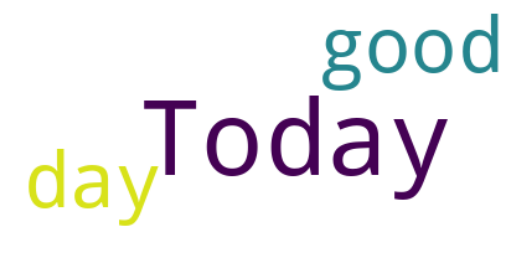

In [30]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

my_stopwords=set(STOPWORDS)
my_stopwords.update(['the','a','an'])
my_cloud=WordCloud(background_color='white', stopwords=my_stopwords).generate(string)
plt.imshow(my_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [29]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
import pandas as pd

my_stopwords=ENGLISH_STOP_WORDS.union(['the'])
vect=CountVectorizer(token_pattern=r'\b[a-z]+\b',input='content', stop_words=my_stopwords) 
string_vect=vect.fit_transform([string])
pd.DataFrame(string_vect.toarray(), columns=vect.get_feature_names_out())

,day,good,today
0,1,1,1


In [39]:
import nltk 
from nltk import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
string_tokens=word_tokenize(string)

porter=PorterStemmer()
snowball=SnowballStemmer("dutch")
WNlemmatizer=WordNetLemmatizer()
print([porter.stem(token) for token in string_tokens])
print(snowball.stem('beginnen'))
print(WNlemmatizer.lemmatize('wonderful', pos='a')) #'a' - adjective, 'n' - noun

['today', 'is', 'a', 'good', 'day', '.']
beginn
wonderful


In [25]:
from langdetect import detect_langs
foreign="Este libro ha sido uno de los mejors libros que he leido"
detect_langs(foreign)

[es:0.9999943617637173]

In [44]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(string)

{'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'compound': 0.4404}

In [ ]:
import matplotlib as mpl
from mpl.toolkits.basemap import Basemap
m=Basemap(projection='merc',llcrnrlat=-35.62, llcrnrlon=-17.29, urcrnrlat=37.73, urcrnrlon=51.39)
m.fillcontinents(color='white',zorder=0)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')

m.scatter(<lons>,<lats>, latlon=True, c=<column>, cmap=<colormap>, alpha=0.7)